## Hands-On: Astrofísica e Cosmologia Computacional
### Parte 3 - Monte Carlo Markov Chains e Análise Bayesiana de Dados

Objetivos:
- Explorar o algoritmo de Metropolis-Hastings
- Discutir o custo computacional e otimizações (paralelização, clusters)
- Obter vínculos nos parâmetros cosmológicos a partir dos mapas observacionais (GetDist)
  - Vínculos marginalizados 1D
  - Vínculos 2D em *corner plots*
- Comparação de modelos via minimização
- Discutir algoritmos mais sofisticados (nested sampling, emuladores)

Plano:
- 14h-15h30: montar código e rodar MCMCs
- 16h-17h30: apresentação e discussão dos resultados

## Estatística Bayesiana

É uma mudança no conceito de probabilidade, aplicável a experimentos não repetíveis.
- Frequentista: $P(x) = \lim_{N \to \infty} \frac{N_x}{N}$, onde $N_x$ é a quantidade de vezes que o experimento resulta em $x$
- Bayesiana: $P(x)$ é o grau de confiança que temos no resultado $x$, assumindo perfeito conhecimento de toda a informação apresentada

Na estatística Bayesiana, tudo que não temos perfeito conhecimento é uma variável aleatória. No nosso caso, os dados são variáveis aleatórias (sujeitos a incertezas na medição, por exemplo), o próprio modelo teórico $\mathcal{M}$ e seus parâmetros $\theta$ são variáveis aleatórias.

Nesse contexto, o teorema de Bayes pode ser interpretado da seguinte forma:
\begin{equation*}
    P(\theta | \mathrm{data}, \mathcal{M}) = \frac{P(\mathrm{data} | \theta, \mathcal{M})P(\theta | \mathcal{M})}{P(\mathrm{data} | \mathcal{M})}
\end{equation*}

Cada termo tem um significado:
- $P(\theta | \mathrm{data}, \mathcal{M})$ é a **distribuição posterior**, ou seja, a probabilidade dos parâmetros $\theta$ depois que os dados são levados em conta;
- $P(\mathrm{data} | \theta, \mathcal{M})$ é a **função de verossimilhança** (ou **likelihood**), a probabilidade de os dados serem medidos assumindo que o modelo $\mathcal{M}$ com parâmetros $\theta$ é o modelo correto;
- $P(\theta | \mathcal{M})$ é a **distribuição a priori** (ou **prior**), a confiança dada aos parâmetros $\theta$ antes de levar os dados em conta. Geralmente, o prior é uniforme.
- $P(\mathrm{data} | \mathcal{M})$ é a **evidência Bayesiana** do modelo, uma quantidade utilizada em análise comparativa de modelos.

O objetivo de uma análise é explorar a função posterior. Uma maneira de fazer isso é a partir de métodos de Cadeias de Markov de Monte Carlo (MCMCs).

Vamos começar com um exemplo simples: em 1998, Adam Riess e colaboradores realizaram o trabalho de observação e análise de dados de supernovas que estabeleceu o modelo $\Lambda\mathrm{CDM}$ e ganhou o prêmio Nobel em 2011. A Figura 6 do artigo https://arxiv.org/pdf/astro-ph/9805201 mostra que as supernovas favorecem uma expansão acelerada, indicando pela primeira vez a existência de energia escura.

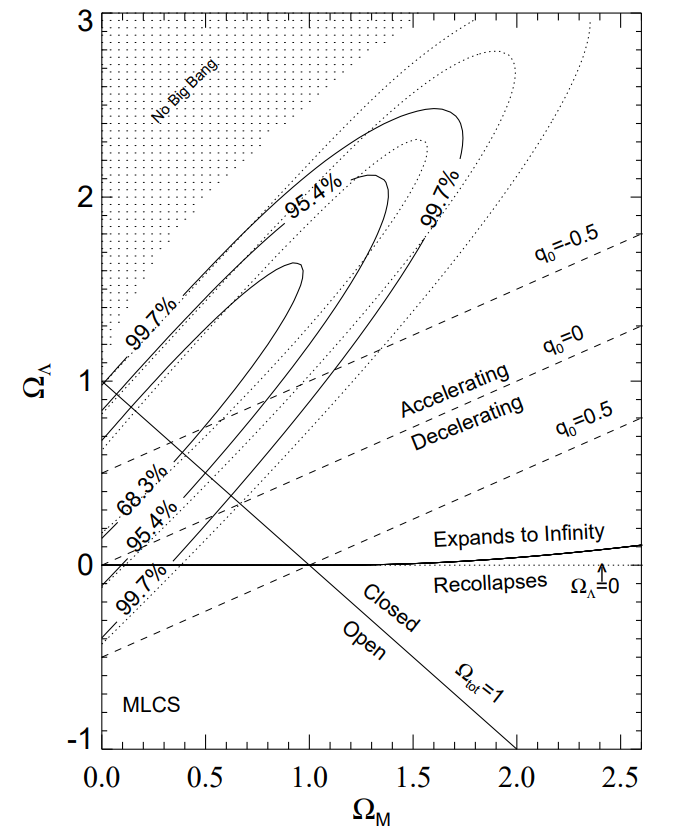

In [8]:
from IPython.display import Image
Image("./riess.png")

Os dados consistem de redshifts $z$ associados a *distance moduli*, um proxy da distância de luminosidade definido por
\begin{equation*}
    \mu = 5\log\left(\frac{D_L}{1\mathrm{Mpc}}\right) + 25
\end{equation*}
A distância de luminosidade até um redshift $z$ é dada por
\begin{equation*}
    D_L = \frac{c(1+z)}{H_0}S_k(H_0\chi),
\end{equation*}
onde $\chi$ é a distância radial comóvel,
\begin{equation*}
    \chi = \int_0^z \frac{dz}{H(z)},
\end{equation*}
e
\begin{equation*}
    S_k(x) = \begin{cases}
        x, \text{ if } \Omega_k = 0,  \\
        \frac{1}{\sqrt\Omega_k}\sinh(\sqrt\Omega_k x), \text{ if } \Omega_k > 0, \\
        \frac{1}{\sqrt{-\Omega_k}}\sin(\sqrt{-\Omega_k} x), \text{ if } \Omega_k < 0.
    \end{cases}
\end{equation*}

Cada medida $\mu_i$ tem uma incerteza instrumental $\sigma_i$ associada. Além disso, os redshifts são medidos com uma incerteza $\sigma_v$ associada à velocidade peculiar de objetos nas galáxias.

Definimos a likelihood da seguinte maneira. Primeiro, a função $\chi^2$ descreve quão bem o modelo teórico se ajusta aos dados, com um peso associado às barras de erro:
\begin{equation*}
    \chi^2 = \sum_i \frac{(\mu(z_i, \theta) - \mu_i)^2}{\sigma_i^2 + \sigma_v^2}
\end{equation*}

In [3]:
from time import time
from random import uniform
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt

import getdist
from getdist import plots

import data.sn_riess as sn

In [4]:
def S_k(x, omegak):
    sqrt_omegak = np.sqrt(np.abs(omegak))
    if omegak == 0: return x
    elif omegak > 0: return np.sinh(sqrt_omegak*x)/sqrt_omegak
    elif omegak < 0: return np.sin(sqrt_omegak*x)/sqrt_omegak

def lum_dist(z, omegam, omegal, H0):
    omegak = 1 - omegam - omegal
    integrand = lambda z: 1/np.sqrt((1+z)**2*(1+omegam*z) - z*(2+z)*omegal)
    integral = quad(integrand, 0, z)[0]
    return sn.c*(1+z)/H0 * S_k(integral, omegak)

def chi2(model):
    om, ol, h0 = model
    if np.any(om*(1+sn.zs)**3 + (1 - om - ol)*(1+sn.zs)**2 + ol < 0): return np.nan
    lum_dists = np.array([lum_dist(z, *model) for z in sn.zs])
    mus_th = 5*np.log10(lum_dists) + 25
    return np.sum((mus_th - sn.mus)**2/(sn.sigmas**2 + sn.sigma_vel_disp**2))

Concordância (H0 = 67): chi2 = 40.329752321430334
Concordância (H0 = 30): chi2 = 2902.772437966095
Einstein-de Sitter: chi2 = 106.83320017442911


<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_11593/2019472525.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$D_L(z) (\mathrm{Mpc})$")


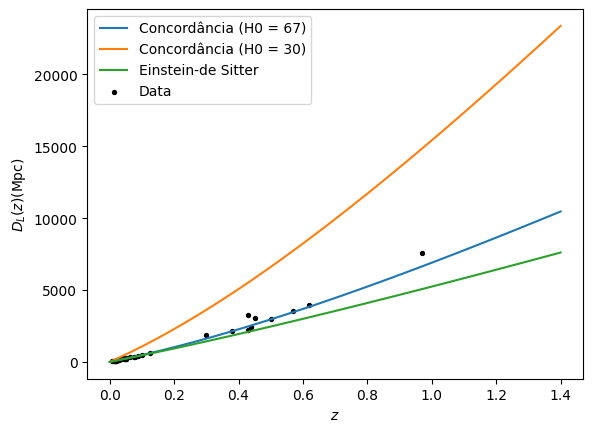

In [33]:
models = {
    "Concordância (H0 = 67)": (0.3, 0.7, 67), # Modelo LambdaCDM de concordância
    "Concordância (H0 = 30)": (0.3, 0.7, 30), # Modelo LambdaCDM de concordância
    "Einstein-de Sitter": (1.0, 0.0, 67),     # Modelo Einstein-de Sitter (sem energia escura)
}

zs = np.linspace(0, 1.4, 50)
for label, model in models.items():
    print(f"{label}: chi2 = {chi2(model)}")
    plt.plot(zs, [lum_dist(z, *model) for z in zs], label=label)
plt.scatter(sn.zs, 10**((sn.mus - 25)/5), color="black", s=8, label="Data")
plt.xlabel("$z$")
plt.ylabel("$D_L(z) (\mathrm{Mpc})$")
plt.legend()

Podemos então modelar a likelihood da seguinte forma:
\begin{equation*}
    P(\mathrm{data} | \theta, \mathcal{M}) = \mathcal{L}(\theta) = \mathcal{N}e^{-\frac{\chi^2}{2}}.
\end{equation*}

Para outros dados mais gerais e possivelmente correlacionados, a expressão acima ainda é correta, mas $\chi^2$ agora precisa de uma matriz $\mathcal{C}$, a **matriz de covariância dos dados**. Juntando todas as quantidades observáveis em um vetor $\mathbf{d}$, o **data vector**, e todas as previsões teóricas correspondentes em um vetor $\mathbf{t}$, o **theory vector**, temos que
\begin{equation*}
    \chi^2 = (\mathbf{d} - \mathbf{t})^T \cdot \mathcal{C} \cdot (\mathbf{d} - \mathbf{t}) = \sum_{i,j} (d_i - t_i) \mathcal{C}_{ij} (d_j - t_j)
\end{equation*}

## Cadeias de Markov de Monte Carlo
Por mais que consigamos explorar o espaço de parâmetros desse caso simples, ainda precisamos de resultados quantitativos mais claros sobre os parâmetros cosmológicos. Uma maneira de obter resultados estatísticos da distribuição posterior é obter um conjunto de amostras de parâmetros $\theta$ que seguem $P(\theta | \mathrm{data}, \mathcal{M}). Um algoritmo utilizado é o algoritmo de Metropolis-Hastings.

In [ ]:
class MCMCWalker:
    """
        Helper class for managing MCMCs. The class contains methods for performing Monte Carlo steps and saves the state.
    """
    def __init__(self):
        # Hard-coding an initial point based on the exploration
        initial_om = 0.3
        initial_ol = 0.7
        initial_h0 = 67
        initial_params = [initial_om, initial_ol, initial_h0]
        initial_chi2 = chi2(initial_params)
        initial_sample = {
            'params': initial_params,
            'chi2': initial_chi2,
            'weight': 1,
        }
        self.samples = [initial_sample]

    def accept_sample(self, params, chi2):
        sample = {
            'params': params,
            'chi2': chi2,
            'weight': 1
        }
        self.samples.append(sample)

    def step(self):
        while True:
            current_chi2 = self.samples[-1]['chi2']
            new_om = self.samples[-1]['params'][0] + uniform(-0.25, 0.25)
            new_ol = self.samples[-1]['params'][1] + uniform(-0.25, 0.25)
            new_h0 = self.samples[-1]['params'][2] + uniform(-2.0, 2.0)
            new_params = [new_om, new_ol, new_h0]
            if new_h0 < 60 or new_h0 > 80 or new_om < 0 or new_om > 1 or new_ol < -1 or new_ol > 3:
                # Reject point outside the prior
                self.samples[-1]['weight'] += 1
                continue
            new_chi2 = chi2(new_params)
            if new_chi2 == np.nan:
                # Reject points that have problematic chi2
                self.samples[-1]['weight'] += 1
                continue
            if new_chi2 < current_chi2:
                self.accept_sample(new_params, new_chi2)
                break
            else:
                r = uniform(0, 1)
                if r < np.exp(-(new_chi2 - current_chi2)/2):
                    self.accept_sample(new_params, new_chi2)
                    break
                else:
                    self.samples[-1]['weight'] += 1 # Increment weight
                    continue
    
    def gelman_rubin(self, n_split):
        all_params = np.array(
            [sample['params'] for sample in self.samples]
        )[:-(len(self.samples)%n_split)]
        np.random.shuffle(all_params)
        split_params = np.split(all_params, n_split)
        avg = np.mean(split_params, axis=1)
        std = np.std(split_params, axis=1)
        avg_of_std = np.mean(std, axis=0)
        std_of_avg = np.std(avg, axis=0)
        R_minus_one = std_of_avg/avg_of_std
        return np.max(R_minus_one)

def run_mcmc():
  w = MCMCWalker()
  print("Starting MCMC")
  start = time()
  while True:
      for _ in range(1000): w.step()
      R_minus_one = w.gelman_rubin(4)
      print(f"At {len(w.samples)} samples, R-1 = {R_minus_one}")
      if R_minus_one < 0.01: break 
  print(f"MCMC Converged! Took {time() - start:.2f} seconds")
  return w

In [24]:
w = run_mcmc()

Starting MCMC
At 1001 samples, R-1 = 0.07564857107917966
At 2001 samples, R-1 = 0.041825938302859245
At 3001 samples, R-1 = 0.048545518044976824
At 4001 samples, R-1 = 0.030567666764774237
At 5001 samples, R-1 = 0.02908428330472321
At 6001 samples, R-1 = 0.026399245529158802
At 7001 samples, R-1 = 0.0247691319207938
At 8001 samples, R-1 = 0.0210118273012075
At 9001 samples, R-1 = 0.01521059525305255


/tmp/ipykernel_11593/1540132177.py:17: RuntimeWarning: invalid value encountered in log10
  mus_th = 5*np.log10(lum_dists) + 25


At 10001 samples, R-1 = 0.027997848725885562
At 11001 samples, R-1 = 0.013001431279799932
At 12001 samples, R-1 = 0.014092755538241618
At 13001 samples, R-1 = 0.015129318355718022
At 14001 samples, R-1 = 0.019550267290486777
At 15001 samples, R-1 = 0.011221193261616528
At 16001 samples, R-1 = 0.014870774874560642
At 17001 samples, R-1 = 0.011125009547130709
At 18001 samples, R-1 = 0.02378919024208636
At 19001 samples, R-1 = 0.01962681560493657
At 20001 samples, R-1 = 0.011234447568516142
At 21001 samples, R-1 = 0.006992095027998884
MCMC Converged! Took 53.14 seconds


## Otimizações de MCMC
No nosso exemplo, cada passo de Monte Carlo é computacionalmente barato: cada chamada da função `chi2` dura menos de 0.1s. Esse não é o caso de MCMCs cosmológicas, que chamam códigos que resolvem equações diferenciais complexas. Em casos reais, podemos aplicar algumas otimizações:
- *Ajustar o proposal*: um proposal uniforme não leva em conta correlações entre parâmetros, e por isso leva a uma baixa taxa de aceitação. Uma escolha que maximiza a taxa de aceitação é usar um proposal gaussiano de média zero e uma covariância sendo a covariância amostral (dado um número mínimo de amostras). Se a covariância do posterior já é conhecida, esta pode ser utilizada já de início. **Vocês fizeram uma matriz de Fisher com Guilherme, não é mesmo?**
- *Speed hierarchy*: ao variarmos, por exemplo, o parâmetro $\Omega_m$, precisamos resolver novamente todas as equações de Einstein-Boltzmann, o passo mais demorado da pipeline. Se, por exemplo, variamos apenas $A_s$, as funções de transferência não mudam e não precisamos resolver as equações novamente! Códigos modernos fazem um *fast-slow split* dos parâmetros, a fim de computar mais variações de parâmetros rápidos (como $A_s$) do que lentos (como $\Omega_m$)
- *Inferência acelerada por Machine Learning*: códigos de Einstein-Boltzmann são o gargalo de análises cosmológicas. Uma possível maneira de acelerar MCMCs é treinando algum modelo de machine learning (redes neurais, processos gaussianos, etc) para obter as previsões teóricas ($C_\ell$'s) em função dos parâmetros cosmológicos. Cada chamada de um código de Einstein-Boltzmann dura da ordem de 1 segundo, enquanto modelos de machine learning simples duram da ordem de 1 milissegundo

## GetDist: Análise Estatística de MCMCs

O pacote [`getdist`](https://getdist.readthedocs.io/en/latest/) é usado para processar amostras de MCMCs e obter resultados estatísticos. A análise usa o almoritmo de **Kernel Density Estimation (KDE)** para transformar as amostras em uma distribuição contínua. Vamos utilizar o `getdist` para obter intervalos de confiança e corner plots.

In [26]:
def getdist_chain(w):
    """
        Função auxiliar que transforma as amostras cruas em um objeto `getdist.MCSamples`
        A função também define parâmetros derivados `q0` e `Omega_k`
    """
    mcmc = getdist.MCSamples(
    samples=np.array([sample['params'] + [sample['chi2']] for sample in w.samples]),
    weights=np.array([sample['weight'] for sample in w.samples]),
    names=["Omega_m", "Omega_Lambda", "H0", "chi2"],
    labels=["\\Omega_m", "\\Omega_\\Lambda", "H_0", "\\chi^2"],
    ranges={"Omega_m": (0, None)}
    )
    mcmc.removeBurn(0.3)
    mcmc.addDerived(mcmc["Omega_m"]/2 - mcmc["Omega_Lambda"], name="q0", label="q_0")
    mcmc.addDerived(1 - mcmc["Omega_Lambda"] - mcmc["Omega_m"], name="Omega_k", label="\\Omega_k")
    return mcmc

chain = getdist_chain(w)

Removed no burn in


In [27]:
# Obter intervalos de confiança 1D
print("1D confidence intervals (68%):")
for param in ["H0", "Omega_m", "Omega_Lambda", "q0", "Omega_k"]:
  print(chain.getInlineLatex(param, limit=1))

1D confidence intervals (68%):
H_0 = 65.1\pm 1.3
\Omega_m < 0.547
\Omega_\Lambda = 0.91^{+0.38}_{-0.43}
q_0 = -0.71\pm 0.29
\Omega_k = -0.33^{+0.77}_{-0.55}


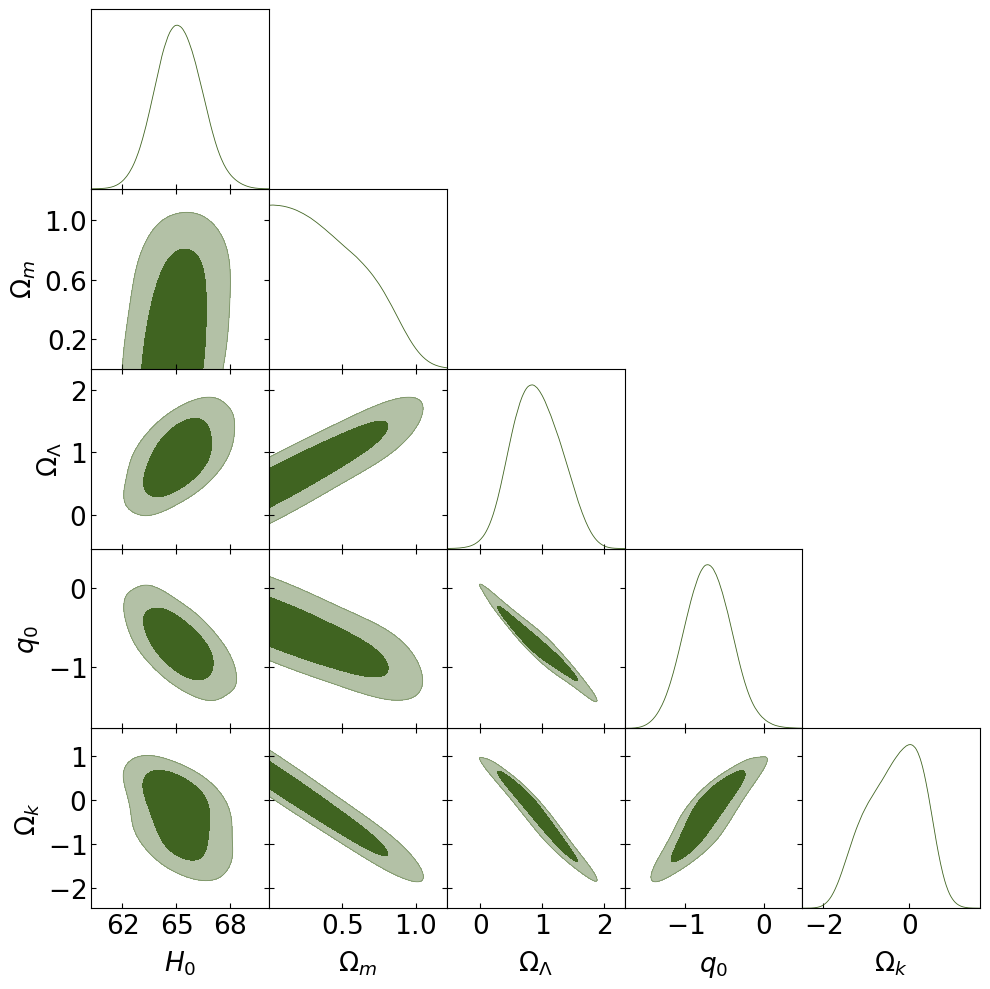

In [42]:
# Obtendo contornos de confiança 2D, o corner plot
p = getdist.plots.get_subplot_plotter()
p.settings.axes_fontsize=22
p.settings.axes_labelsize=22
p.triangle_plot(
    chain,
    params=["H0", "Omega_m", "Omega_Lambda", "q0", "Omega_k"],
    filled=True,
    contour_colors=["#406421"]
)
p.export("mcmc_sn.pdf")

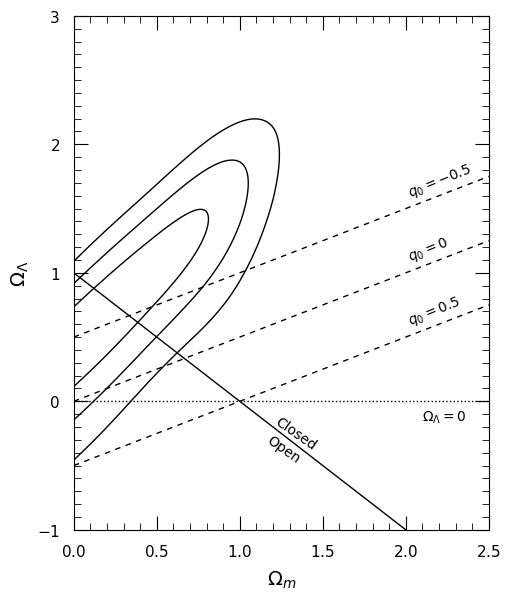

In [29]:
# Reproduzindo a figura do artigo
g = plots.get_single_plotter(width_inch=5, ratio=30/25)
g.settings.num_plot_contours = 3
ax = g.get_axes()
chain.updateSettings({"contours": [0.68, 0.95, 0.997]})
g.plot_2d(chain, "Omega_m", "Omega_Lambda", ls='-', lws=1)
ax.set_xlim([0, 2.5])
ax.set_ylim([-1, 3])

# Deceleration parameter lines
om = np.linspace(0, 2.5, 50)
ol = om/2 # q_0 = 0
ax.plot(om, ol, color="black", ls="--", lw=1, dashes=(4, 4))
ax.text(2.0, ol[-7], r"$q_0 = 0$", rotation=22)
ol = om/2 - 0.5 # q_0 = 0.5
ax.plot(om, ol, color="black", ls="--", lw=1, dashes=(4, 4))
ax.text(2.0, ol[-7], r"$q_0 = 0.5$", rotation=22)
ol = om/2 + 0.5 # q_0 = -0.5
ax.plot(om, ol, color="black", ls="--", lw=1, dashes=(4, 4))
ax.text(2.0, ol[-7], r"$q_0 = -0.5$", rotation=22)

# Closed/Open line
ol = 1 - om
ax.plot(om, ol, color="black", ls="-", lw=1)
ax.text(1.2, ol[-23], "Closed", rotation=-35)
ax.text(1.15, ol[-21], "Open", rotation=-35)

# Omega_Lambda = 0
ol = 0*om
ax.plot(om, ol, color="black", ls=":", lw=1)
ax.text(2.1, -0.15, r"$\Omega_\Lambda = 0$")

ax.set_xticks(np.arange(0, 2.51, 0.1), minor=True)
ax.set_yticks(np.arange(-1, 3, 0.1), minor=True)
ax.tick_params(direction="in", length=10, top=True, right=True, pad=10)
ax.tick_params(which="minor", direction="in", length=5, top=True, right=True)
g.export("riess_reproduction.pdf")

# Análise de Comparação de Modelos
Temos uma MCMC para os dados de supernovas assumindo o modelo $\Lambda$CDM com curvatura e energia escura. Será que a energia escura é realmente necessária?

Vamos comparar alguns modelos:
- Einstein-de Sitter ($\Omega_m = 1$, $\Omega_k = \Omega_\Lambda = 0$),
- Apenas matéria e curvatura, $\Omega_\Lambda = 0$,
- $\Lambda\mathrm{CDM}$ com curvatura,
- $\Lambda\mathrm{CDM}$ sem curvatura.

Observe que o primeiro modelo é uma generalização dos outros dois.

Técnicas de seleção de modelo se baseiam no **máximo global** da likelihood. Vamos usar `scipy` para minimizar a função $\chi^2$.

In [30]:
initial = chain.samples[np.argmin(chain["chi2"])][:3]
r_eds       = minimize(chi2, initial, constraints=[{'type': 'ineq', 'fun': lambda x: x[0]}, {'type': 'eq', 'fun': lambda x: x[1]}, {'type': 'eq', 'fun': lambda x: x[0] - 1}])
r_eds_curv  = minimize(chi2, [0.3, 0.7, 65], constraints=[{'type': 'ineq', 'fun': lambda x: x[0]}, {'type': 'eq', 'fun': lambda x: x[1]}])
r_lcdm_curv = minimize(chi2, initial, constraints=[{'type': 'ineq', 'fun': lambda x: x[0]}])
r_lcdm_flat = minimize(chi2, [0.3, 0.7, 65], constraints=[{'type': 'ineq', 'fun': lambda x: x[0]}, {'type': 'eq', 'fun': lambda x: x[0] + x[1] - 1}])

In [56]:
param_names = ["Omega_m", "Omega_Lambda", "H0"]
print(f"Sem dark energy, sem curvatura: chi2 mínimo = {r_eds.fun:.4f}, parâmetros {[(name, float(value)) for (name, value) in zip(param_names, r_eds.x)]}")
print(f"Sem dark energy, com curvatura: chi2 mínimo = {r_eds_curv.fun:.4f}, parâmetros {[(name, float(value)) for (name, value) in zip(param_names, r_eds_curv.x)]}")
print(f"Com dark energy, sem curvatura: chi2 mínimo = {r_lcdm_flat.fun:.4f}, parâmetros {[(name, float(value)) for (name, value) in zip(param_names, r_lcdm_flat.x)]}")
print(f"Com dark energy, com curvatura: chi2 mínimo = {r_lcdm_curv.fun:.4f}, parâmetros {[(name, float(value)) for (name, value) in zip(param_names, r_lcdm_curv.x)]}")
print(f"Número de supernovas:", len(sn.all))

Sem dark energy, sem curvatura: chi2 mínimo = 63.4447, parâmetros [('Omega_m', 1.0), ('Omega_Lambda', 0.0), ('H0', 60.96017363402195)]
Sem dark energy, com curvatura: chi2 mínimo = 37.2933, parâmetros [('Omega_m', 2.1823831426127515e-15), ('Omega_Lambda', 0.0), ('H0', 63.31828690905203)]
Com dark energy, sem curvatura: chi2 mínimo = 33.8520, parâmetros [('Omega_m', 0.2356518066799857), ('Omega_Lambda', 0.7643481933200142), ('H0', 65.1241367156427)]
Com dark energy, com curvatura: chi2 mínimo = 33.7530, parâmetros [('Omega_m', 0.007225110871732958), ('Omega_Lambda', 0.47870274558361375), ('H0', 64.87259601118168)]
Número de supernovas: 37


Algumas observações:
- O que define um *bom fit*? A partir da expressão
\begin{equation*}
  \chi^2 = \sum_i \frac{(d_i - t_i)^2}{\sigma_i^2},
\end{equation*}
vemos que, se cada previsão teórica $t_i$ dista do dado observado $d_i$ em menos de um desvio padrão, então $\chi^2 < N_\mathrm{data}$, onde $N_\mathrm{data}$ é o número de elementos no seu *data vector*. No nosso caso, possuímos 37 supernovas. Logo, os resultados indicam um bom ajuste dos modelos aos dados observados.
- **Modelos mais gerais fitam melhor os dados.** Se um modelo A difere de outro modelo B por adicionar um parâmetro $p$ extra, e o modelo geral tiver um limite bem-definido para o modelo mais restrito (digamos, $p = 0$), é extremamente provável (estatisticamente falando) que os dados prefiram um parâmetro extra $p \neq 0$.

Conclusão: embora o modelo com curvatura consiga se ajustar melhor aos dados, isso já é esperado. A pergunta é **se a melhora no ajuste vale o aumento na complexidade do modelo**.

Existem alguns métodos de seleção de modelos:
- Akaike Information Criterion (AIC): para um modelo $M$, definimos
\begin{equation*}
  \mathrm{AIC}(M) = \chi^2_\mathrm{min} + 2N_\mathrm{params},
\end{equation*}
onde $\chi^2_\mathrm{min}$ e $N_\mathrm{params}$ são, respectivamente, o mínimo global de $\chi^2$ assumindo o modelo $M$ e o número de parâmetros do modelo $M$. Modelos com menor $\mathrm{AIC}$ são preferíveis. A regra heurística aqui é a que **cada parâmetro adicional deve diminuir $\chi^2$ em pelo menos 2 unidades.**
- Bayesian Information Criterion (BIC): para um modelo $M$, definimos
\begin{equation*}
  \mathrm{BIC}(M) = \chi^2_\mathrm{min} + N_\mathrm{params}\ln(N_\mathrm{data}),
\end{equation*}
onde $\chi^2_\mathrm{min}$ e $N_\mathrm{params}$ são, respectivamente, o mínimo global de $\chi^2$ assumindo o modelo $M$ e o número de parâmetros do modelo $M$. Modelos com menor $\mathrm{AIC}$ são preferíveis. A regra heurística aqui é a que **cada parâmetro adicional deve diminuir $\chi^2$ em pelo menos 2 unidades.**
- Fator de Bayes: o mais complicado dos métodos. O teorema de Bayes implica que
  \begin{equation*}
    p(\theta | \mathrm{data}, M) = \frac{p(\mathrm{data} | \theta, M)p(\theta | M)}{p(\mathrm{data} | M)}.
  \end{equation*}
  O denominador $p(\mathrm{data} | M)$ é a *evidência bayesiana* do modelo, e é igual à integral do numerador (*i.e.* likelihood vezes prior) sobre o espaço de parâmetros. Para dois modelos $M$ e $N$, o fator de Bayes é definido como
  \begin{equation*}
    Z = \log \left(\frac{p(\mathrm{data} | M)}{p(\mathrm{data} | N)}\right).
  \end{equation*}
  A interpretação do fator de Bayes é dada pela escala de Jeffreys:
  - $|Z| < 0.5$: inconclusivo;
  - $0.5 < |Z| < 1$: evidência fraca;
  - $1 < |Z| < 2$: evidência moderada;
  - $|Z| > 2$: evidência forte;
  
  O sinal de $Z$ indica o modelo favorecido: $Z > 0$ favorece o modelo $M$ enquanto $Z < 0$ favorece $N$.

  Como o algoritmo de Metropolis-Hastings não requer normalização da likelihood, MCMCs usuais não fornecem informação sobre a evidência bayesiana. A evidência pode ser calculada através de algoritmos de *nested sampling*, que são mais sofisticados e eficientes do que Metropolis-Hastings.

In [32]:
aic_eds       = r_eds.fun + 2*1
aic_eds_curv  = r_eds_curv.fun + 2*2
aic_lcdm_flat = r_lcdm_flat.fun + 2*2
aic_lcdm_curv = r_lcdm_curv.fun + 2*3
bic_eds       = r_eds.fun + np.log(len(sn.all))*1
bic_eds_curv  = r_eds_curv.fun + np.log(len(sn.all))*2
bic_lcdm_flat = r_lcdm_flat.fun + np.log(len(sn.all))*2
bic_lcdm_curv = r_lcdm_curv.fun + np.log(len(sn.all))*3
print(f"Sem dark energy, sem curvatura: AIC = {aic_eds}, BIC = {bic_eds}")
print(f"Sem dark energy, com curvatura: AIC = {aic_eds_curv}, BIC = {bic_eds_curv}")
print(f"Com dark energy, sem curvatura: AIC = {aic_lcdm_flat}, BIC = {bic_lcdm_flat}")
print(f"Com dark energy, com curvatura: AIC = {aic_lcdm_curv}, BIC = {bic_lcdm_curv}")

Sem dark energy, sem curvatura: AIC = 65.4446712201525, BIC = 67.05558913279673
Sem dark energy, com curvatura: AIC = 41.29330433649237, BIC = 44.51514016178082
Com dark energy, sem curvatura: AIC = 37.85195304825705, BIC = 41.0737888735455
Com dark energy, com curvatura: AIC = 39.75303544518693, BIC = 44.5857891831196


Usando o AIC e o BIC, o modelo preferido é o $\Lambda\mathrm{CDM}$ sem curvatura! Embora o $\Lambda\mathrm{CDM}$ com curvatura consiga prover o melhor ajuste aos dados, a complexidade adicional não vale a pena dada a pequena melhora.

# Cobaya

`Cobaya` é um *framework* de análise Bayesiana de dados cosmológicos. O código oferece:
- *Likelihoods* de vários dados (CMB, supernovas, BAO...)
- Interface com códigos teóricos comuns como `CLASS` e `CAMB`
- Implementação de Metropolis-Hastings e minimizadores

O exemplo de supernovas é um caso simplista: apenas três parâmetros livres e a previsão teórica pode ser calculada muito rapidamente. Em análises reais:
- A previsão teórica precisa de seis parâmetros cosmológicos mais dezenas de *parâmetros de nuisance* (necessários para modelar erros sistemáticos do experimento). Quanto mais parâmetros livres na MCMC, mais passos são necessários para a convergência. No nosso exemplo, a cadeia converge em aproximadamente 20k amostras; cadeias reais costumam convergir com ~200k+ amostras
- A previsão teórica passa pela solução das equações de Einstein-Boltzmann (perturbações lineares). Distâncias são facilmente computáveis, mas a solução das equações de perturbação é mais complexa, e demora O(1s)

# Paralelização

Entender paralelização é importante para lidar com computações em grande escala. O processador do computador possui múltiplos núcleos, e programas comuns utilizam apenas um núcleo. Isso permite que o computador faça várias tarefas concorrentemente.

Podemos, no entanto, programar códigos para que usem mais de um núcleo ao desempenhar tarefas. Por exemplo, se duas partes de cálculo podem ser feitas independentemente, então podemos "entregá-las" a núcleos diferentes e em seguida combinar o resultado.

Existem dois modelos de paralelização:
- *Multithreading*: ocorre quando um processo (no sentido computacional, ou seja, cada entrada do "gerenciador de tarefas") utiliza mais de um núcleo do processador. Os núcleos compartilham da mesma memória, ou seja, eles podem operar sobre os mesmos dados.
- *Multiprocessing*: ocorre quando um programa abre mais de um processo no computador, cada processo usando apenas um núcleo. Processos não compartilham memória, mas podem se comunicar a fim de trocar informações.

Vários programas se utilizam das duas técnicas para otimizar seus resultados. No caso do `Cobaya`:
- Cada cadeia consiste em múltiplos "walkers" que percorrem o espaço de parâmetros. **Cada walker consiste em um processo (multiprocessing)**. Periodicamente, os walkers trocam informação entre si para verificar a convergência da cadeia.
- Cada walker precisa chamar o `CLASS` para obter a previsão teórica e calcular a likelihood. O `CLASS` resolve o sistema de equações de Einstein-Boltzmann para diferentes valores de `k` (número de onda de Fourier). Por serem equações lineares, cada `k` gera um sistema de equações independentes, **que são resolvidas em paralelo usando multithreading**.

# Clusters

Paralelização consiste em técnicas que tiram vantagem de recursos computacionais; no entanto, nossos computadores pessoais possuem poucos núcleos. Felizmente, universidades possuem computadores grandes com vários processadores: os *clusters*.

MCMCs são tarefas computacionais caras que demoram dias para completar, mesmo empregando muitos processadores. *Clusters* fornecem uma ferramenta para conduzir computações caras (e a universidade paga o custo da eletricidade). O departamento de Cosmologia e Interações Fundamentais (COSMO) possui o CHE, um pequeno cluster que atende às necessidades do grupo.